# Kaggle - Help to Protect the Great Barrier Reef

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!nvidia-smi

Tue Apr 19 20:36:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Make sure to run COTS_download.ipynb and COTS_previsulization.ipynb ahead or download dataset to your drive, change the relative paths and change the label to YOLO format.**

## Environment Preparation

### Install Libraries

In [5]:
! pip install wandb -qqq
! pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code

     |████████████████████████████████| 1.8 MB 9.7 MB/s 
     |████████████████████████████████| 181 kB 54.3 MB/s 
     |████████████████████████████████| 144 kB 54.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 3.3 MB 9.1 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 34.5 MB 1.2 MB/s 


### Import Libraries

In [6]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys

from joblib import Parallel, delayed

from IPython.display import display


In [7]:
# Use Weights & Biases (W&B) MLOps platform for tracking the experiments
# Log in to your W&B account

import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Metadata Setting

In [8]:
FOLD      = 1 # which fold to train
DIM       = 3000 
MODEL     = 'yolov5s6'
BATCH     = 4
EPOCHS    = 10
OPTMIZER  = 'Adam'

PROJECT   = 'great-barrier-reef-test' # w&b in yolov5
NAME      = f'{MODEL}-dim{DIM}-fold{FOLD}-epoch{EPOCHS}' # w&b for yolov5

REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/content/drive/MyDrive/Protect_Reef' # directory to save original data
IMAGE_DIR = '/content/drive/MyDrive/Protect_Reef_Process/images' # directory to save images
LABEL_DIR = '/content/drive/MyDrive/Protect_Reef_Process/labels' # directory to save labels

## Create Directory

In [9]:
# !mkdir -p {IMAGE_DIR}
# !mkdir -p {LABEL_DIR}

## Get Path

In [10]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path
0,0,40258,0,0,0-0,[],/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...
1,0,40258,1,1,0-1,[],/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...


## Check the Number of BBOX

In [11]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


## Clean Data

In [12]:
# Only train the model using data with annotations (bbox)
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

## Helper Function

In [13]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [14]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[559, 213, 50, 32]]"
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[558, 213, 50, 32]]"


## Get Image Size
All images have same dimension [1280, 720].

In [15]:
df['width']  = 1280
df['height'] = 720
display(df.head(2))

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes,width,height
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[559, 213, 50, 32]]",1280,720
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[558, 213, 50, 32]]",1280,720


## Create Folds
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [16]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df.video_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

0    2143
1    2099
2     677
Name: fold, dtype: int64

## Dataset Split

In [17]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(2820, 2099)

## Configuration
The dataset config file requires:

1. The dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths)
2. The number of classes nc and
3. A list of class names:['cots']

In [18]:
model_path = '/content/drive/MyDrive/Protect_Reef_Process/' + MODEL
!mkdir -p {model_path}
# Change the working directory
os.chdir(model_path)
print(os.getcwd())

/content/drive/MyDrive/Protect_Reef_Processyolov5s6


In [19]:
import yaml

cwd = '/content/drive/MyDrive/Protect_Reef_Model'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  =  model_path,
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'gbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'gbr.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- cots
nc: 1
path: /content/drive/MyDrive/Protect_Reef_Processyolov5s6
train: /content/drive/MyDrive/Protect_Reef_Model/train.txt
val: /content/drive/MyDrive/Protect_Reef_Model/val.txt



In [20]:
%%writefile /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml
lr0: 0.001  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.5  # image mosaic (probability)
mixup: 0.5 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Overwriting /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml


## YOLOV5 Setting

In [21]:
os.chdir('/content')
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.2/166.8 GB disk)


## Model Training

In [22]:
!python train.py --img {DIM} --batch {BATCH} --epochs {EPOCHS} --optimizer {OPTMIZER} --data /content/drive/MyDrive/Protect_Reef_Model/gbr.yaml --hyp /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml --weights {MODEL}.pt --project {PROJECT} --name {NAME} --exist-ok

wandb: Currently logged in as: erisedtang (use `wandb login --relogin` to force relogin)
train: weights=yolov5s6.pt, cfg=, data=/content/drive/MyDrive/Protect_Reef_Model/gbr.yaml, hyp=/content/drive/MyDrive/Protect_Reef_Model/hyp.yaml, epochs=10, batch_size=4, imgsz=3000, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=great-barrier-reef-test, name=yolov5s6-dim3000-fold1-epoch10, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.001, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, war

## Output File

In [23]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)
!ls {OUTPUT_DIR}

events.out.tfevents.1650400671.de0f2118b003.493.0  train_batch0.jpg
hyp.yaml					   train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   weights
opt.yaml


In [24]:
shutil.copytree(OUTPUT_DIR, model_path + '/result')

'/content/drive/MyDrive/Protect_Reef_Processyolov5s6/result'

### Class Distribution

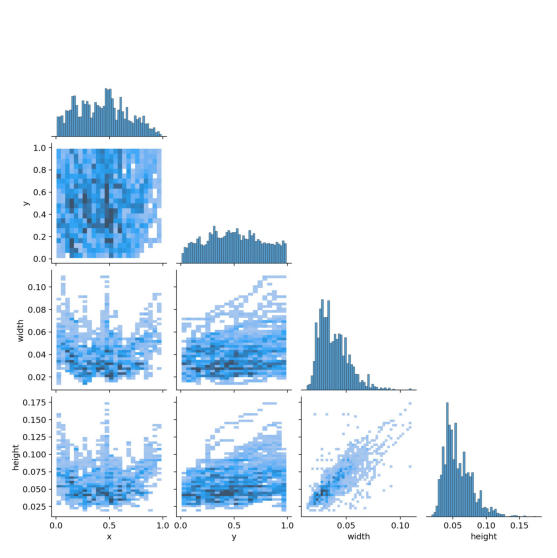

In [25]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels_correlogram.jpg'));

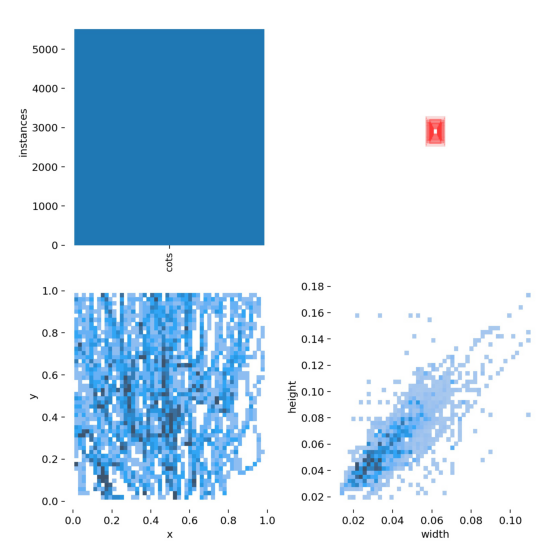

In [26]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels.jpg'));

### Batch Size

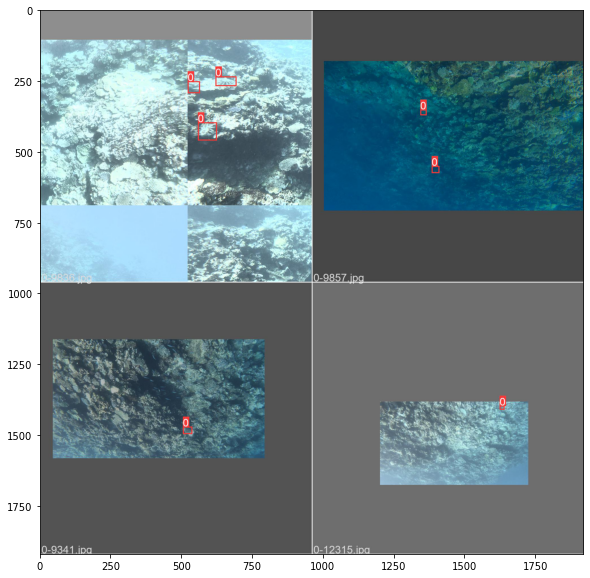

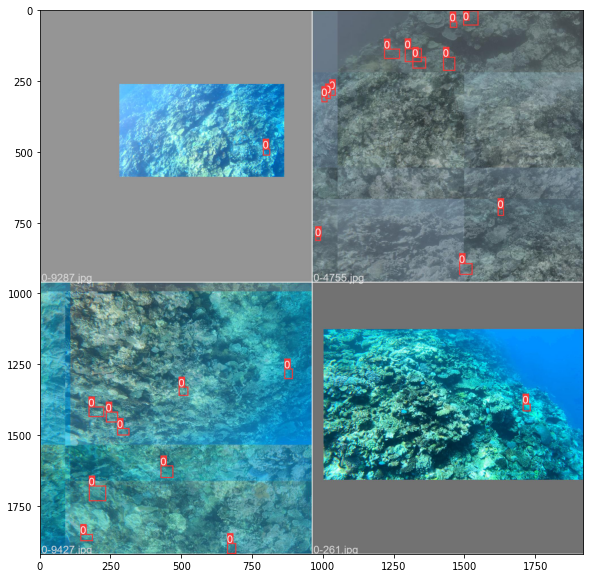

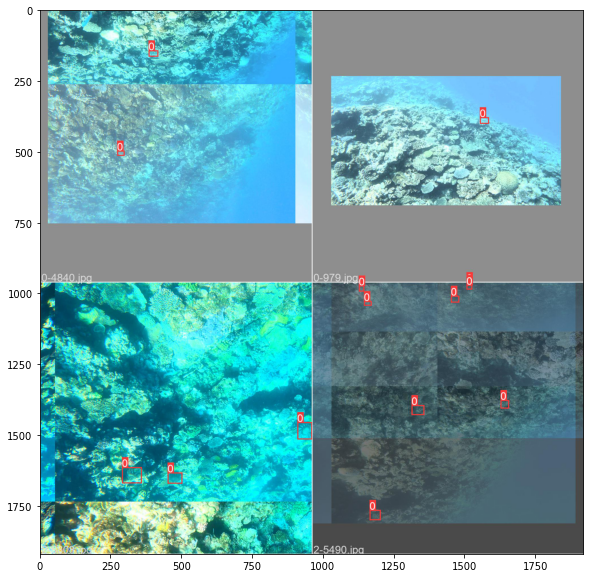

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch2.jpg'))

### Ground True V.S. Predict

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

## Result

### Score V.S. Epoch

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

### Confusion Matrix

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

### Metrics

In [ ]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'));
    plt.show()